In [148]:
import pandas as pd
import ast
import glob
import os

import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [149]:
df = pd.read_excel("../preprocessed_cars/new_cleaned_entire_dataset.xlsx")

In [150]:
df['Car_Model'] = df['Car_Model'].str.split().str[0]
df = df.drop(['Top_Features', 'Comfort_and_Convenience', 'Interior_Features', 'Exterior_Features', 'Safety_Features', 'Entertainment_and_Communication'], axis = 1)

In [151]:
def encoding_datas(df):
    le = LabelEncoder()
    df['Insurance_Validity_Period'] = le.fit_transform(df['Insurance_Validity_Period'])
    nominal_cols = ['Car_Model', 'Fuel_Type', 'Transmission_Type', 'Battery_Type', 'city']
    df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)
    boolean_cols = df.select_dtypes(include=['bool']).columns
    df[boolean_cols] = df[boolean_cols].astype(int)
    return df

In [152]:
def replace_integers(x):
    if isinstance(x, int):
        return 'unknown'
    elif isinstance(x, float):
        return 'unknown'
    else:
        return x

In [153]:
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return x 

In [154]:
def one_hot_encode_list_columns(df):
    one_hot_encoded_df = pd.DataFrame()
    list_like_cols = ['Top_Features', 'Comfort_and_Convenience', 'Interior_Features', 'Exterior_Features', 'Safety_Features', 'Entertainment_and_Communication']

    for col in list_like_cols:
        df[col] = df[col].apply(replace_integers)
        df[col] = df[col].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else x)
        # Extract unique features
        unique_features = set()
        for features in df[col]:
            unique_features.update(features)

        unique_features = list(unique_features)

        print(f'City of {df['city'][0]}, {len(unique_features)} differnt features for {col}')

        # Create a DataFrame for one-hot encoded columns
        one_hot_encoded_df = pd.DataFrame()

        for feature in unique_features:
            one_hot_encoded_df[f'{col}_{feature}'] = df[col].apply(lambda x: 1 if feature in x else 0)

        # Concatenate the new DataFrame with the original DataFrame
        df = pd.concat([df.drop(columns=[col]), one_hot_encoded_df], axis=1)
        
    return df

In [156]:
# df = one_hot_encode_list_columns(df)

In [157]:
df = encoding_datas(df)

In [158]:
numerical_columns = ['Number_of_Seats', 'Mileage_(km/l)', 'Engine_Capacity', 'Maximum_Power', 
                         'Torque', 'Wheel_Size', 'Kilometers_Driven', 'Number_of_Owners', 
                         'Model_Year', 'Listed_Price', 'Actual_Price']

In [159]:
summary_stats = df[numerical_columns].dtypes

In [160]:
summary_stats

Number_of_Seats        int64
Mileage_(km/l)       float64
Engine_Capacity      float64
Maximum_Power        float64
Torque               float64
Wheel_Size           float64
Kilometers_Driven      int64
Number_of_Owners       int64
Model_Year             int64
Listed_Price         float64
Actual_Price         float64
dtype: object

In [161]:
df.select_dtypes(exclude=['int64', 'float64']).columns

Index([], dtype='object')

In [162]:
## Descriptive Statistics
df[numerical_columns].describe()

,Number_of_Seats,Mileage_(km/l),Engine_Capacity,Maximum_Power,Torque,Wheel_Size,Kilometers_Driven,Number_of_Owners,Model_Year,Listed_Price,Actual_Price
count,8369.000000,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8.369000e+03,8.369000e+03
mean,5.203131,19.252806,1424.670496,7.647381e+05,179.137514,15.692528,5.897430e+04,1.360139,2016.503286,8.890303e+07,8.893126e+07
std,0.663573,3.961567,477.816936,3.353721e+07,108.431513,1.229770,7.406100e+04,0.641958,3.921465,7.914973e+08,7.914978e+08
min,2.000000,7.080000,0.000000,2.540000e+01,7.800000,12.000000,0.000000e+00,0.000000,1985.000000,1.000000e+05,1.194336e+05
25%,5.000000,17.010000,1197.000000,7.890000e+01,111.700000,15.000000,3.000000e+04,1.000000,2014.000000,4.000000e+05,4.310932e+05
50%,5.000000,19.000000,1248.000000,8.870000e+01,144.000000,15.683188,5.369200e+04,1.000000,2017.000000,6.190000e+05,6.460000e+05
75%,5.000000,21.400000,1498.000000,1.213000e+02,215.000000,16.000000,8.000000e+04,2.000000,2019.000000,9.750000e+05,1.007093e+06
max,10.000000,140.000000,5000.000000,1.652244e+09,850.000000,21.000000,5.500000e+06,5.000000,2023.000000,9.970300e+09,9.970335e+09


Data Visualization

In [163]:
corr_numerical = df[numerical_columns].corr()


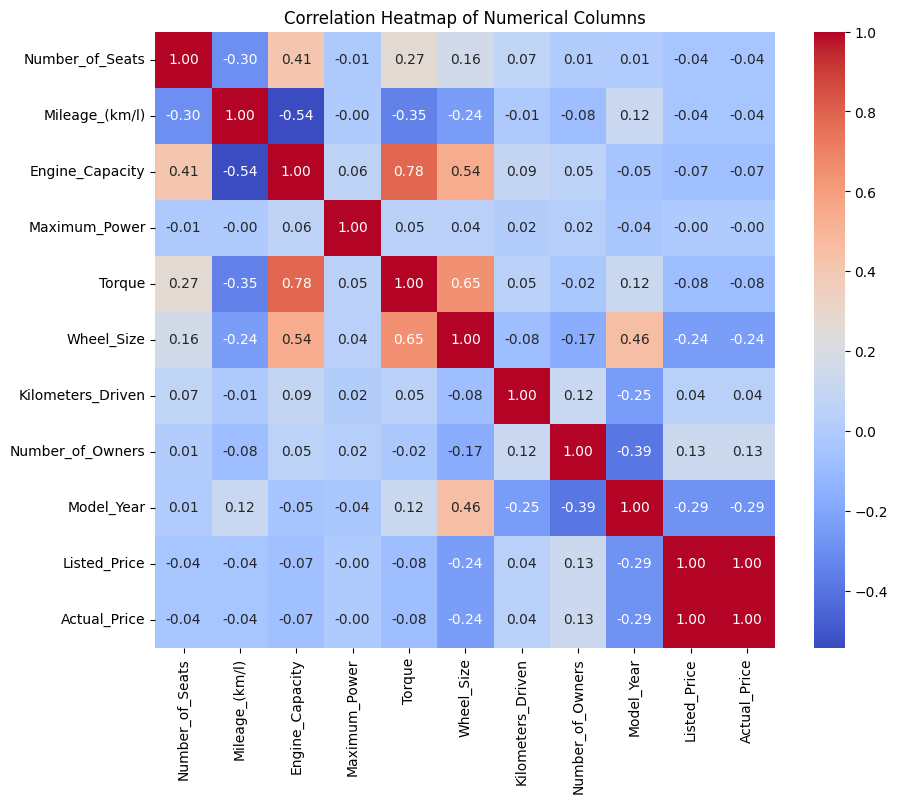

In [164]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_numerical, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

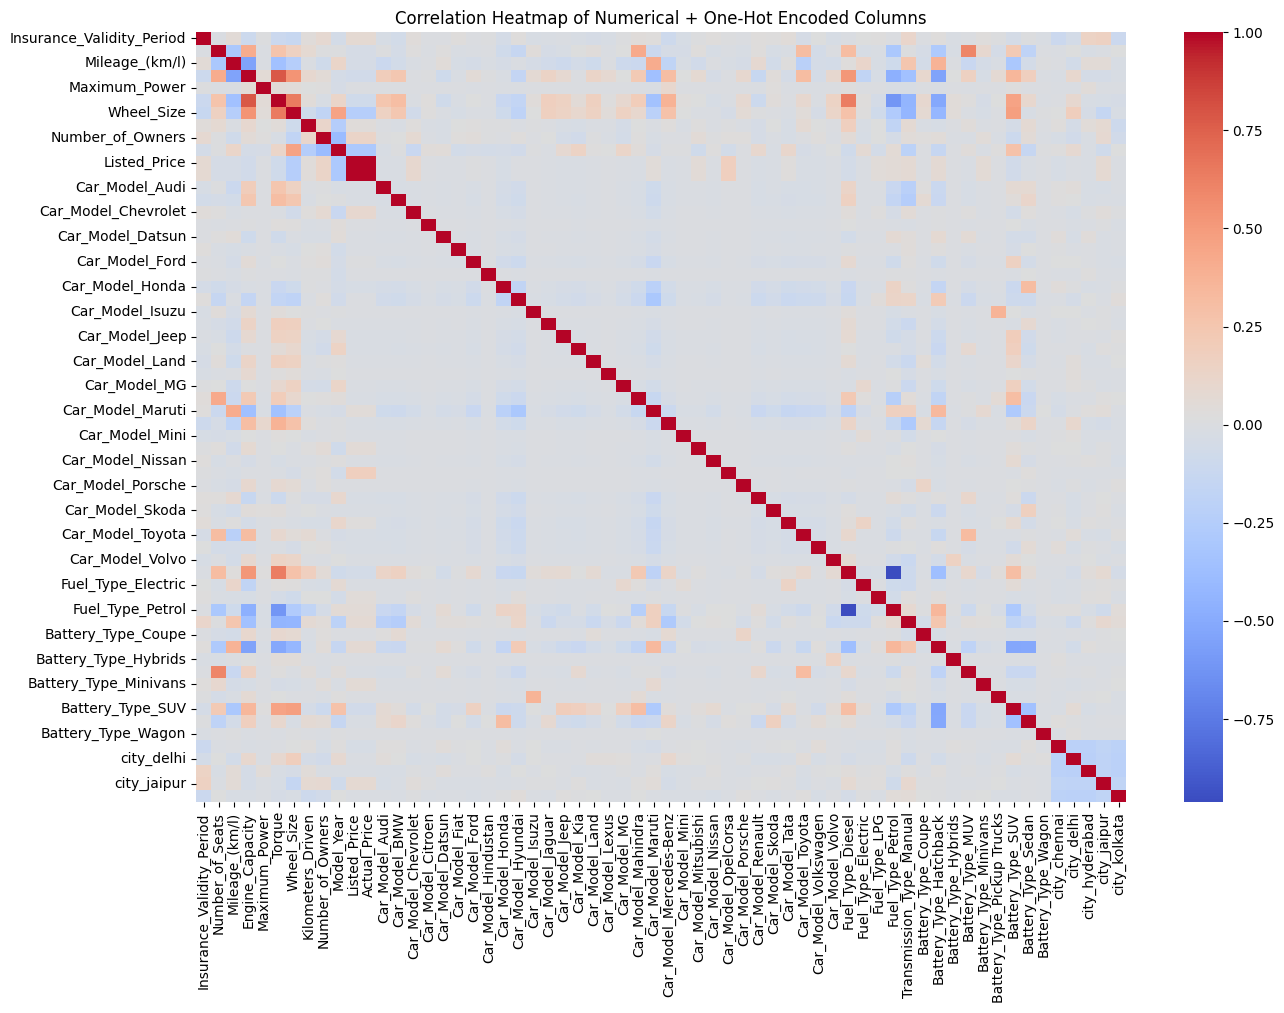

In [165]:
# Calculate correlation matrix
corr_combined = df.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_combined, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical + One-Hot Encoded Columns')
plt.show()

In [166]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you are predicting a numerical target variable
X = df.drop('Listed_Price', axis=1)  # Features
y = df['Listed_Price']               # Target variable

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [167]:
zero_importance_features = feature_importances[feature_importances['Importance'] == 0]['Feature']

In [168]:
zero_importance_features

18    Car_Model_Hindustan
35      Car_Model_Porsche
Name: Feature, dtype: object

In [169]:
df_reduced = df.drop(columns=zero_importance_features)

In [113]:
# # Calculate correlation matrix
# corr_combined = df_reduced.corr()

# # Plot heatmap
# plt.figure(figsize=(15, 10))
# sns.heatmap(corr_combined, annot=False, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap of Numerical + One-Hot Encoded Columns')
# plt.show()

In [170]:
## Remove outliers

def remove_outliers(df, numerical_columns):
    for col in numerical_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


In [171]:
df_reduced = remove_outliers(df_reduced, numerical_columns)

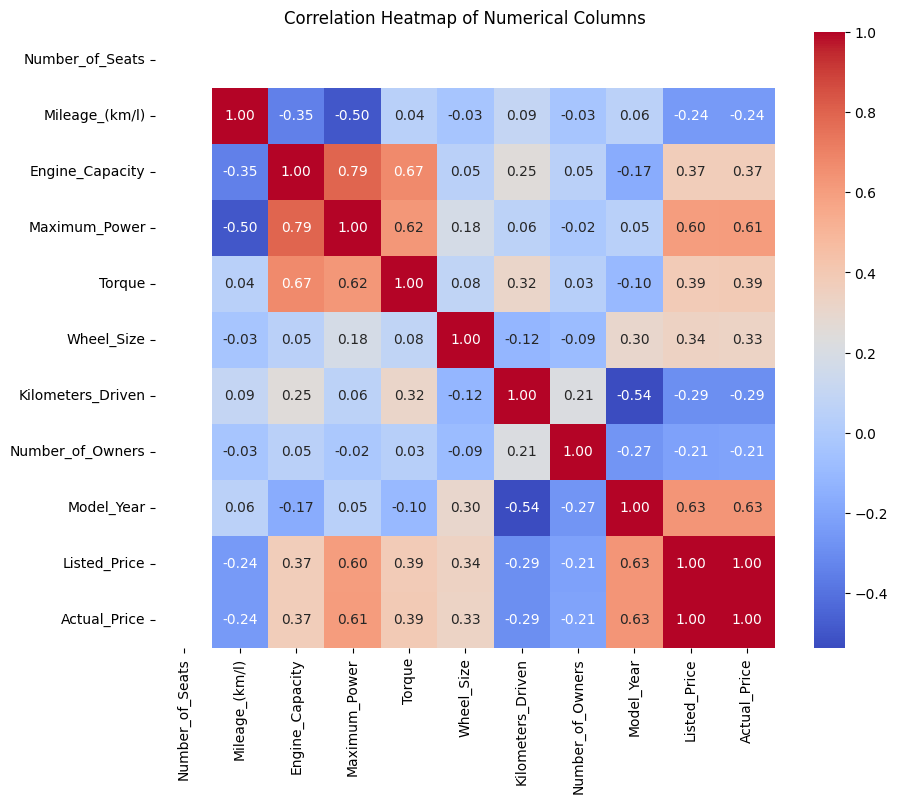

In [172]:
corr_numerical = df_reduced[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_numerical, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

In [173]:
df_reduced.describe()

,Insurance_Validity_Period,Number_of_Seats,Mileage_(km/l),Engine_Capacity,Maximum_Power,Torque,Wheel_Size,Kilometers_Driven,Number_of_Owners,Model_Year,...,Battery_Type_Minivans,Battery_Type_Pickup Trucks,Battery_Type_SUV,Battery_Type_Sedan,Battery_Type_Wagon,city_chennai,city_delhi,city_hyderabad,city_jaipur,city_kolkata
count,5244.000000,5244.0,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,...,5244.000000,5244.0,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000
mean,1.424104,5.0,20.308136,1236.772883,87.490059,135.660631,15.495932,55199.498093,1.303776,2016.989321,...,0.001526,0.0,0.174294,0.266209,0.000191,0.178299,0.161709,0.190313,0.121663,0.170290
std,1.321256,0.0,2.819657,207.314717,19.286064,46.019518,0.652661,29941.570442,0.536497,2.944441,...,0.039032,0.0,0.379399,0.442017,0.013809,0.382801,0.368218,0.392585,0.326927,0.375923
min,0.000000,5.0,11.900000,793.000000,47.000000,24.000000,14.000000,0.000000,0.000000,2009.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.0,18.300000,1197.000000,74.000000,110.000000,15.000000,31000.000000,1.000000,2015.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,5.0,20.355000,1197.000000,84.000000,114.700000,15.623656,51866.500000,1.000000,2017.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,5.0,22.320000,1399.000000,98.960000,160.000000,16.000000,75000.000000,2.000000,2019.000000,...,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,5.0,28.000000,1896.000000,148.000000,260.000000,17.000000,143185.000000,3.000000,2023.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [182]:
from sklearn.preprocessing import MinMaxScaler

# Assuming `df` is your DataFrame and `numerical_columns` is a list of columns to normalize
scaler = MinMaxScaler()
df_reduced[numerical_columns] = scaler.fit_transform(df_reduced[numerical_columns])

In [183]:
df_reduced.describe()

,Insurance_Validity_Period,Number_of_Seats,Mileage_(km/l),Engine_Capacity,Maximum_Power,Torque,Wheel_Size,Kilometers_Driven,Number_of_Owners,Model_Year,...,Battery_Type_Minivans,Battery_Type_Pickup Trucks,Battery_Type_SUV,Battery_Type_Sedan,Battery_Type_Wagon,city_chennai,city_delhi,city_hyderabad,city_jaipur,city_kolkata
count,5244.000000,5244.0,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,...,5244.000000,5244.0,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000
mean,1.424104,0.0,0.522244,0.402333,0.400892,0.473138,0.498644,0.385512,0.434592,0.570666,...,0.001526,0.0,0.174294,0.266209,0.000191,0.178299,0.161709,0.190313,0.121663,0.170290
std,1.321256,0.0,0.175134,0.187955,0.190951,0.194998,0.217554,0.209111,0.178832,0.210317,...,0.039032,0.0,0.379399,0.442017,0.013809,0.382801,0.368218,0.392585,0.326927,0.375923
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.397516,0.366274,0.267327,0.364407,0.333333,0.216503,0.333333,0.428571,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.0,0.525155,0.366274,0.366337,0.384322,0.541219,0.362234,0.333333,0.571429,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.0,0.647205,0.549411,0.514455,0.576271,0.666667,0.523798,0.666667,0.714286,...,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [181]:
# df_new = df_reduced[(df_reduced['Maximum_Power'] < 1000) & (df_reduced['Maximum_Power'] > 100)]  # Replace 1000 and 100 with suitable thresholds


In [47]:
# #Data Visualization
# numeric_df = df.select_dtypes(include=['float64', 'int64'])

# # Calculate the correlation
# plt.figure(figsize=(12,8))
# corr = numeric_df.corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap')
# plt.show()

In [116]:
df_reduced[['Actual_Price','Listed_Price']]

,Actual_Price,Listed_Price
0,0.000031,0.000030
1,0.000072,0.000071
2,0.000049,0.000049
3,0.000037,0.000036
4,0.000070,0.000069
...,...,...
8364,0.000043,0.000041
8365,0.000010,0.000008
8366,0.000047,0.000045
8367,0.000006,0.000004


In [184]:
##Model Developement

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [191]:
X = df_reduced.drop(['Listed_Price', 'Actual_Price'], axis=1)  # Features
y = df_reduced['Listed_Price']               # Target variable

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [193]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=50)  # Number of features to keep
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=50)

In [194]:
# Get the selected features' mask (True for selected features)
selected_features = X_train.columns[rfe.support_]

# Transform the training and testing sets to include only the selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

In [195]:
# Train the linear regression model on the selected features
model_rfe = LinearRegression()
model_rfe.fit(X_train_rfe, y_train)

# Make predictions on the test set with the selected features
y_pred_rfe = model_rfe.predict(X_test_rfe)

from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse_rfe = mean_squared_error(y_test, y_pred_rfe)
rmse_rfe = np.sqrt(mse_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

print(f'Mean Squared Error: {mse_rfe}')
print(f'Root Mean Squared Error: {rmse_rfe}')
print(f'R² Score: {r2_rfe}')


Mean Squared Error: 0.006023705610054093
Root Mean Squared Error: 0.07761253513482273
R² Score: 0.8572551637100668


In [196]:
# Assuming you already have X and y as your features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=30, random_state=20)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}') 
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')



Mean Squared Error: 0.004266675994167452
Root Mean Squared Error: 0.06531979787298374
R² Score: 0.8994880022669782


## Creating pipeline for the model 

In [69]:
def remove_outliers(df, numerical_columns):
    for col in numerical_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


In [70]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


In [71]:
# class EncodingDataTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         le = LabelEncoder()
#         X['Insurance_Validity_Period'] = le.fit_transform(X['Insurance_Validity_Period'])
#         nominal_cols = ['Car_Model', 'Fuel_Type', 'Transmission_Type', 'Battery_Type', 'city']
#         X = pd.get_dummies(X, columns=nominal_cols, drop_first=True)
#         boolean_cols = X.select_dtypes(include=['bool']).columns
#         X[boolean_cols] = X[boolean_cols].astype(int)
#         return X


In [72]:
# # Custom transformer for removing outliers
# class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, numerical_columns):
#         self.numerical_columns = numerical_columns

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         rows_to_keep = pd.Series([True] * len(X), index=X.index)
        
#         for col in self.numerical_columns:
#             Q1 = X[col].quantile(0.25)
#             Q3 = X[col].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR
#             rows_to_keep &= (X[col] >= lower_bound) & (X[col] <= upper_bound)

#         filtered_X = X[rows_to_keep]
#         filtered_y = y[rows_to_keep] if y is not None else None
        
#         return filtered_X, filtered_y
        

In [73]:
# Define numerical columns (exclude 'Listed_Price' for outlier removal)
numerical_columns = ['Number_of_Seats', 'Mileage_(km/l)', 'Engine_Capacity', 'Maximum_Power', 
                      'Torque', 'Wheel_Size', 'Kilometers_Driven', 'Number_of_Owners', 
                      'Model_Year', 'Listed_Price']

categorical_columns = ['Insurance_Validity_Period', 'Fuel_Type', 'Transmission_Type', 'Battery_Type', 'Car_Model', 'city']


In [74]:
df = pd.read_excel("../preprocessed_cars/new_cleaned_entire_dataset.xlsx")
df['Car_Model'] = df['Car_Model'].str.split().str[0]
df = df.drop(['Actual_Price','Top_Features', 'Comfort_and_Convenience', 'Interior_Features', 'Exterior_Features', 'Safety_Features', 'Entertainment_and_Communication'], axis = 1)

df = remove_outliers(df, numerical_columns)

In [75]:
X = df.drop(columns=['Listed_Price'])
y = df['Listed_Price']    


In [76]:
X.head()

,Insurance_Validity_Period,Fuel_Type,Number_of_Seats,Transmission_Type,Mileage_(km/l),Engine_Capacity,Maximum_Power,Torque,Wheel_Size,Battery_Type,Kilometers_Driven,Number_of_Owners,Car_Model,Model_Year,city
0,Third Party,Petrol,5,Manual,23.10,998.0,67.04,90.00,15.683188,Hatchback,120000,3,Maruti,2015,bangalore
1,Comprehensive,Petrol,5,Manual,17.00,1497.0,121.31,150.00,16.000000,SUV,32706,2,Ford,2018,bangalore
2,Comprehensive,Petrol,5,Manual,23.84,1199.0,84.00,114.00,14.000000,Hatchback,11949,1,Tata,2018,bangalore
3,Comprehensive,Petrol,5,Manual,19.10,1197.0,81.86,113.75,14.000000,Sedan,17794,1,Hyundai,2014,bangalore
4,Third Party,Diesel,5,Manual,23.65,1248.0,88.50,200.00,16.000000,SUV,60000,1,Maruti,2015,bangalore


In [77]:
numerical_columns =['Number_of_Seats', 'Mileage_(km/l)', 'Engine_Capacity', 'Maximum_Power', 
                      'Torque', 'Wheel_Size', 'Kilometers_Driven', 'Number_of_Owners', 
                      'Model_Year']
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', ColumnTransformer(
        transformers=[
            # Handle numerical columns
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
                ('scaler', StandardScaler())  # Scale numerical features
            ]), numerical_columns),
            
            # Handle categorical columns using OneHotEncoder with 'ignore' for unknown categories
            ('cat', Pipeline(steps=[
                ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
            ]), categorical_columns)
        ],
        remainder='passthrough'  # Leave other columns unchanged
    )),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # RandomForestRegressor model
])


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [78]:
print(X.shape)
print(y.shape)

(5310, 15)
(5310,)


In [79]:
print(X_train.shape)
print(y_train.shape)

(4248, 15)
(4248,)


In [80]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Number_of_Seats',
                                                   'Mileage_(km/l)',
                                                   'Engine_Capacity',
                                                   'Maximum_Power', 'Torque',
                                                   'Wheel_Size',
                                                   'Kilometers_Driven',
                                                   'Number_of_Owners',
                                                   'Model_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Insurance_Validity_Period',
                                                   'Fuel_Type',
                                                   'Transmission_Type',
                                                   'Battery_Type', 'Car_Model',
                                                   'city'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [81]:
# Predict on the test set
y_pred = pipeline.predict(X_test)


In [82]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Optional: Check feature shapes to ensure consistency
print(f"Training feature shape: {X_train.shape}")
print(f"Test feature shape: {X_test.shape}")

Mean Absolute Error: 51763.02856653704
Mean Squared Error: 5640966923.86018
R-squared: 0.9025077696800305
Training feature shape: (4248, 15)
Test feature shape: (1062, 15)


In [49]:
# Save the pipeline to a pickle file
with open('../pickle_file/pipeline_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [83]:
X.head()

,Insurance_Validity_Period,Fuel_Type,Number_of_Seats,Transmission_Type,Mileage_(km/l),Engine_Capacity,Maximum_Power,Torque,Wheel_Size,Battery_Type,Kilometers_Driven,Number_of_Owners,Car_Model,Model_Year,city
0,Third Party,Petrol,5,Manual,23.10,998.0,67.04,90.00,15.683188,Hatchback,120000,3,Maruti,2015,bangalore
1,Comprehensive,Petrol,5,Manual,17.00,1497.0,121.31,150.00,16.000000,SUV,32706,2,Ford,2018,bangalore
2,Comprehensive,Petrol,5,Manual,23.84,1199.0,84.00,114.00,14.000000,Hatchback,11949,1,Tata,2018,bangalore
3,Comprehensive,Petrol,5,Manual,19.10,1197.0,81.86,113.75,14.000000,Sedan,17794,1,Hyundai,2014,bangalore
4,Third Party,Diesel,5,Manual,23.65,1248.0,88.50,200.00,16.000000,SUV,60000,1,Maruti,2015,bangalore


In [84]:
X.Transmission_Type.value_counts()

Transmission_Type
Manual       4328
Automatic     982
Name: count, dtype: int64

In [87]:
pipeline.predict(['Comprehensive', 'Diesel', 5, 'Automatic', 25.10, 1000, 80.03, 80.0, 18.00, 'Sedan', 50000, 1, 'Audi', 2017, 'chennai'])

ValueError: Expected 2D array, got 1D array instead:
array=['Comprehensive' 'Diesel' 5 'Automatic' 25.1 1000 80.03 80.0 18.0 'Sedan'
 50000 1 'Audi' 2017 'chennai'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [96]:
import pandas as pd

# Define custom input values as a DataFrame
custom_df = pd.DataFrame([{
    'Number_of_Seats': 7,
    'Mileage_(km/l)': 25.10,
    'Engine_Capacity': 800,
    'Maximum_Power': 80.03,
    'Torque': 100.0,
    'Wheel_Size': 18.00,
    'Kilometers_Driven': 50000,
    'Number_of_Owners': 1,
    'Model_Year': 2021,
    'Car_Model': 'Audi',
    'Fuel_Type': 'Diesel',
    'Transmission_Type': 'Automatic',
    'Battery_Type': 'Lithium-ion',  # Ensure this value is correct
    'city': 'Chennai',
    'Insurance_Validity_Period': 'Comprehensive'
}])

# Use the pipeline to predict with the custom DataFrame
custom_prediction = pipeline.predict(custom_df)

print(f'Predicted Listed Price: {custom_prediction[0]}')


Predicted Listed Price: 755060.0


In [95]:
df['Car_Model'].unique()

array(['Maruti', 'Ford', 'Tata', 'Hyundai', 'Datsun', 'Honda', 'Renault',
       'Skoda', 'Volkswagen', 'Mahindra', 'Toyota', 'Nissan', 'Fiat',
       'MG', 'Kia', 'Chevrolet', 'Citroen', 'BMW', 'Mercedes-Benz'],
      dtype=object)